# Validation with the American Gut data

Copyright (c) 2013, The Deblur Development Team.

Please use this notebook with [conda enviroment].

The purpose of this notebook is to evaluate the effects of different deblurring depths on the biological patterns in data from the [American Gut Project](www.americangut.org). We expect the alpha diversity of a bacterial community to significantly increase with age, as previously seen [[1](#1),[2](#2)].

The metadata was downloaded from the American Gut FTP.

In [6]:
!wget ftp://ftp.microbio.me/AmericanGut/ag-July-29-2016/01-raw/metadata.txt || curl -OL ftp://ftp.microbio.me/AmericanGut/ag-July-29-2016/01-raw/metadata.txt
# Moves the downloaded file into the correct directory
import shutil
shutil.move('./metadata.txt', '../data/ag_metadata.txt')

--2016-10-27 17:31:48--  ftp://ftp.microbio.me/AmericanGut/ag-July-29-2016/01-raw/metadata.txt
           => ‘metadata.txt’
Resolving ftp.microbio.me... 169.228.46.98
Connecting to ftp.microbio.me|169.228.46.98|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /AmericanGut/ag-July-29-2016/01-raw ... done.
==> SIZE metadata.txt ... 51322841
==> PASV ... done.    ==> RETR metadata.txt ... done.
Length: 51322841 (49M) (unauthoritative)

metadata.txt        100%[===================>]  48.94M  6.43MB/s    in 7.8s    

2016-10-27 17:31:56 (6.27 MB/s) - ‘metadata.txt’ saved [51322841]



'../data/ag_metadata.txt'

In [8]:
import pandas as pd
map_ = pd.read_csv('../data/ag_metadata.txt', sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)

We'll work with fecal samples from a subset of adults 20-69 with BMIs between 18.5 and 30, no history of diabetes or inflammatory bowel disease who have  not use antibiotics in the past year.

In [9]:
map_ = map_.loc[map_['SUBSET_HEALTHY'].apply(lambda x: x in {'True', 'true'})]
map_ = map_.loc[map_['BODY_HABITAT'] == 'UBERON:feces']

Tables were processed using the methods in [notebook X]().

Alpha diversity was calculated in QIIME 1.9.1, where it is assumed the files are in a folder below the notebook, and sequence depth (i.e. `bloom10`) changes to appropriately reflect the number of filtered sequences.

```
$ multiple_rarefactions_even_depth.py -i ag_alpha_files/ag.pos.min10.withtax.bloom10.biom -d 2000 -o ./rarefaction/10 -n 10

$ alpha_diversity.py -i .ag_alpha_files/rarefaction/10/ -o ag_alpha_files/alpha/10/ -m shannon

$ collate_alpha.py -i ag_alpha_files/alpha/10/ -o ag_alpha_files/alpha/10/
```

The collated alpha diversity files can be downloaded from [location].

We'll import those files, and calculate the mean diversity for each of the rarefaction instances.

In [10]:
import numpy as np
filters = np.array([0, 10, 15, 20])

for i in filters:
    diversity = pd.read_csv('../data/shannon%i.txt' % i, sep='\t', index_col=0)
    map_['shannon_%i' % i] = diversity.mean()

Let's filter out any samples which do not appear after all filtering.

In [11]:
map_ = map_.loc[map_['shannon_%i' % filters.max()].dropna().index]

Now, we can perform the comparisons with age. We'll use a kruskal wallis test, and calculate a test statistic and p-value.

In [12]:
from scipy.stats import kruskal
ages = ['20s', '30s', '40s', '50s', '60s']

kruskal_results = [kruskal(*[map_.loc[map_['AGE_CAT'] == age, 'shannon_%i' % filter_].dropna()
                            for age in ages]) for filter_ in filters]
statitics, p_values = zip(*kruskal_results)

Let's plot our test statitics as a function of filtering depth.

In [14]:
# Sets up pretty plots
from matplotlib import use
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_style('ticks')
% matplotlib inline

# Plots the data
ax = plt.axes()
ax.bar(left=np.arange(0, len(filters)) + 0.1,
       height=statitics,
       width=0.8,
       )
# Formats and labels the axes
ax.set_xticks(np.arange(0.5, len(filters)))
ax.set_xticklabels(map(int, filters))
ax.set_xlabel('Bloom Sequences Removed')
ax.set_ylabel('Kruskal Wallis H statistic')
sn.despine()

# Saves the figure
ax.figure.savefig('bloom_statistic.pdf')

ImportError: dlopen(/Users/jdebelius/miniconda2/envs/bloom/lib/python3.5/site-packages/matplotlib/_png.so, 2): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/jdebelius/miniconda2/envs/bloom/lib/python3.5/site-packages/matplotlib/_png.so
  Reason: Incompatible library version: _png.so requires version 39.0.0 or later, but libpng16.16.dylib provides version 34.0.0

Now, let's plot the negative log of the p-values.

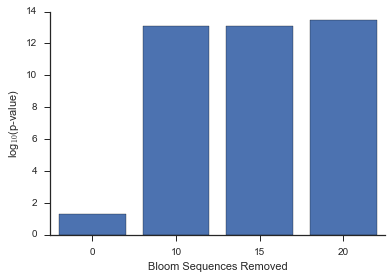

In [58]:
# Plots the data
ax = plt.axes()
ax.bar(left=np.arange(0, len(filters)) + 0.1,
       height=-np.log(np.array(p_values)),
       width=0.8,
       )
# Formats and labels the axes
ax.set_xticks(np.arange(0.5, len(filters)))
ax.set_xticklabels(map(int, filters))
ax.set_xlabel('Bloom Sequences Removed')
ax.set_ylabel('log$_{10}$(p-value)')
sn.despine()

# Saves the figure
ax.figure.savefig('bloom_p-value.pdf')

Therefore, we have demonstrated the ability to see a significant difference with reguard to age in the American Gut population is dependent on the bloom filter depth.

# References

<ol><li>
<a id="1"></a>Yatsunenko, T.; Rey, F.E.; Manary, M.J.; Trehan I.; Dominguez-Bello, M.G.; Contreras, M.; Magris, M.' Hidalgo, G.; Baldassano, R.N.; Anokhin, A.P.; Heath, A.C.; Warner, B.; Reeder, J.; Kuczynski, J.; Caporaso, J.G.; Lozupone, C.A.; Lauber, C.; Clemente, J.C.; Knights, D.; Knight, R.; Gordon, J.I. (2012). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/22699611">Human gut microbiome viewed across age and geography</a>". <em>Nature</em>. <strong>486</strong>: 222-227.
</li><li>
<a id="2"></a>Koenig, J.E.; Spor, A.; Scalfone, N.; Fricker, A.D.; Stombaugh, J.; Knight, R.; Angenent, L.T.; Ley, R.E. (2011). "<a href="https://www.ncbi.nlm.nih.gov/pubmed/20668239">Succession of microbial consortia in the developing infant gut microbiome</a>". <em>PNAS</em>. <strong>108 Suppl 1</strong>: 4578-4585.
</li></ol>